In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import os
import re
import glob
import configargparse

In [76]:
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = [6., 4.]

In [26]:
p = configargparse.ArgParser(description=__doc__)
p.add('-c', '--config_file', is_config_file=True, env_var='CONFIG_FILE', default='config.txt')
p.add('--external_data_dir', required=True)
args = p.parse_known_args()[0]

In [27]:
demos_2015_voters_df = pd.read_csv('../data/demos_2015.csv.gz', compression='gzip', index_col=['fips'])

In [28]:
pres_2012_df = pd.read_csv(
    '../data/cleaned_pres_2012_df.csv.gz', compression='gzip',
    index_col=['fips', 'party']
)
pres_2016_df = pd.read_csv(
    '../data/cleaned_pres_2016_df.csv.gz', compression='gzip',
    index_col=['fips', 'party']
)

In [29]:
county_to_code_mapping = pd.read_csv(os.path.join(
        args.external_data_dir, 'county_election_results_2016/state_county_fips.csv'
    )).set_index('fips')

In [30]:
restricted_counties = pd.read_csv(
    '../data/vra_counties_2015.csv.gz'
).set_index('fips')

In [31]:
full_pres_df = pres_2012_df.join(
    pres_2016_df, how='outer', lsuffix='_2012', rsuffix='_2016'
)

In [32]:
full_pres_df = full_pres_df.join(demos_2015_voters_df[['tot_pop', 'bac_frac', 'wac_frac', 'wa_frac']])

In [33]:
full_pres_df.loc[:, 'vote_change'] = (full_pres_df.votes_2016 - full_pres_df.votes_2012)

In [34]:
full_pres_df.loc[:, 'rel_vote_change'] = full_pres_df.vote_change / full_pres_df.tot_pop.astype(float)

In [35]:
full_pres_df.loc[:, 'norm_rel_vote_change'] = (
    full_pres_df.rel_vote_change - full_pres_df.query('party!="O"').groupby(level=[0]).rel_vote_change.mean()
)

In [36]:
turnout_change = full_pres_df.groupby(level=0).votes_2016.sum() - full_pres_df.groupby(level=0).votes_2012.sum()

In [37]:
full_pres_df = full_pres_df.join(pd.DataFrame(turnout_change, columns=['turnout_change']))

In [38]:
full_pres_df.loc[:, 'rel_turnout_change'] = full_pres_df.turnout_change / full_pres_df.tot_pop.astype(float)

In [39]:
full_pres_df = full_pres_df.join(restricted_counties)

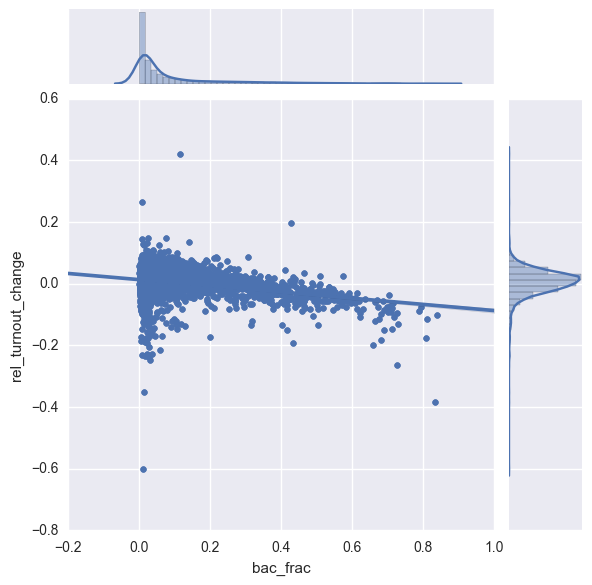

In [40]:
g = sns.JointGrid(data=full_pres_df, x='bac_frac', y='rel_turnout_change')
g.plot_joint(sns.regplot, order=1)
g.plot_marginals(sns.distplot)

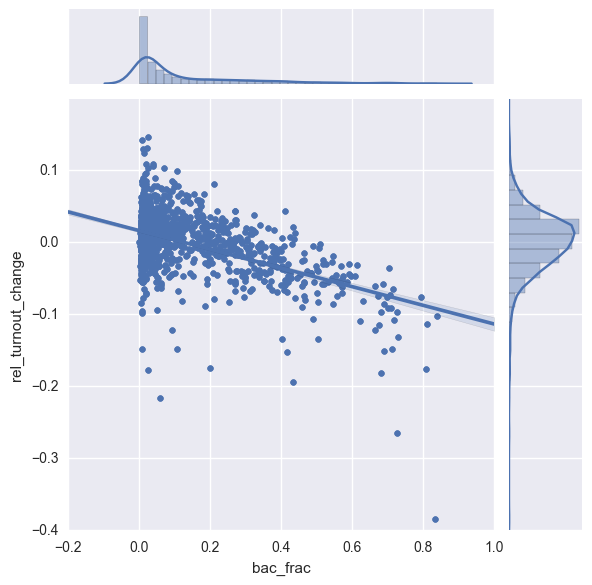

In [41]:
g = sns.JointGrid(
    data=full_pres_df.query('voter_restrictions'), x='bac_frac', y='rel_turnout_change'
)
g.plot_joint(sns.regplot, order=1)
g.plot_marginals(sns.distplot)
plt.ylim(-.4, .2);

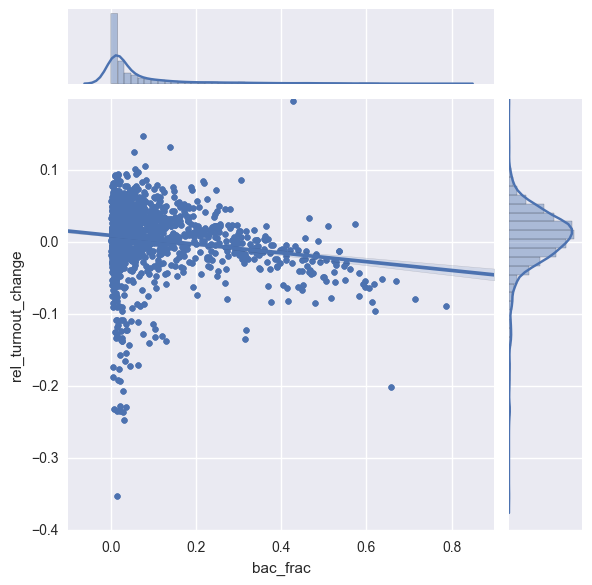

In [42]:
g = sns.JointGrid(
    data=full_pres_df.query('not voter_restrictions'), x='bac_frac', y='rel_turnout_change'
)
g.plot_joint(sns.regplot, order=1)
g.plot_marginals(sns.distplot)
plt.ylim(-.4, .2);

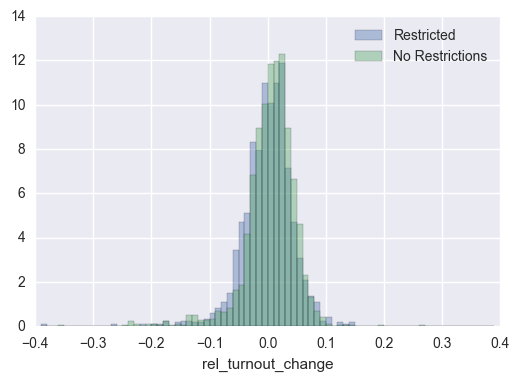

In [43]:
sns.distplot(
    full_pres_df.query('voter_restrictions').rel_turnout_change.dropna(),
    kde=False, norm_hist=True, bins=np.arange(-.4, .4, .01), label='Restricted'
)
sns.distplot(
    full_pres_df.query('not voter_restrictions').rel_turnout_change.dropna(),
    kde=False, norm_hist=True, bins=np.arange(-.4, .4, .01), label='No Restrictions'
)
plt.legend();

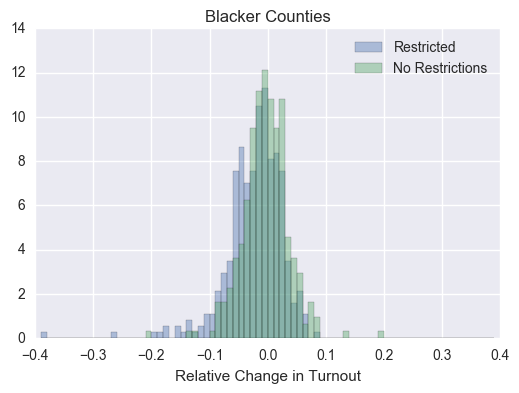

In [55]:
sns.distplot(
    full_pres_df.query('voter_restrictions and bac_frac > 0.13').rel_turnout_change.dropna(),
    kde=False, norm_hist=True, bins=np.arange(-.4, .4, .01), label='Restricted'
)
sns.distplot(
    full_pres_df.query('not voter_restrictions and bac_frac > 0.13').rel_turnout_change.dropna(),
    kde=False, norm_hist=True, bins=np.arange(-.4, .4, .01), label='No Restrictions'
)
plt.title('Blacker Counties')
plt.xlabel('Relative Change in Turnout')
plt.legend();

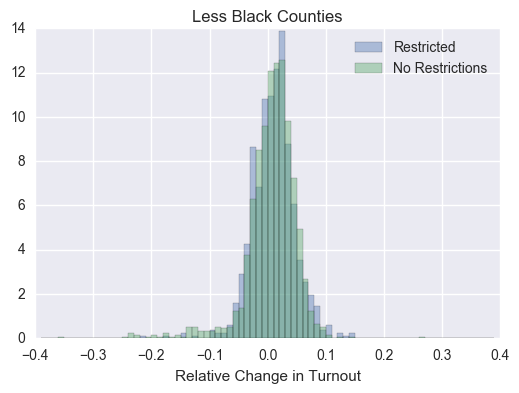

In [74]:
sns.distplot(
    full_pres_df.query('voter_restrictions and bac_frac <= 0.13').rel_turnout_change.dropna(),
    kde=False, norm_hist=True, bins=np.arange(-.4, .4, .01), label='Restricted'
)
sns.distplot(
    full_pres_df.query('not voter_restrictions and bac_frac <= 0.13').rel_turnout_change.dropna(),
    kde=False, norm_hist=True, bins=np.arange(-.4, .4, .01), label='No Restrictions'
)
plt.title('Less Black Counties')
plt.xlabel('Relative Change in Turnout')
plt.legend();

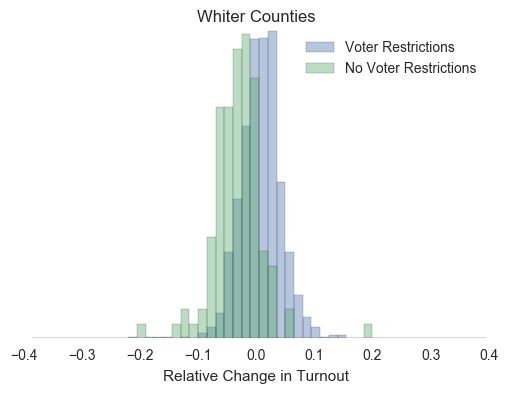

In [84]:
plt.title('Whiter Counties')
sns.distplot(
    full_pres_df.query('voter_restrictions and wa_frac >= 0.63').rel_turnout_change.dropna(),
    kde=False, norm_hist=True, bins=np.arange(-.4, .4, .015), label='Voter Restrictions'
)
sns.distplot(
    full_pres_df.query('not voter_restrictions and wa_frac <= 0.63').rel_turnout_change.dropna(),
    kde=False, norm_hist=True, bins=np.arange(-.4, .4, .015), label='No Voter Restrictions'
)
plt.gca().axes.get_yaxis().set_visible(False)
plt.xlabel('Relative Change in Turnout')
plt.legend();

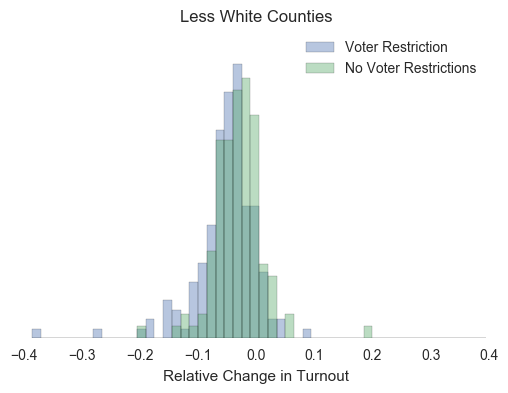

In [105]:
plt.title('Less White Counties')
sns.distplot(
    full_pres_df.query('voter_restrictions and wa_frac < 0.63').rel_turnout_change.dropna(),
    kde=False, norm_hist=True, bins=np.arange(-.4, .4, .015), label='Voter Restriction'
)
sns.distplot(
    full_pres_df.query('not voter_restrictions and wa_frac < 0.63').rel_turnout_change.dropna(),
    kde=False, norm_hist=True, bins=np.arange(-.4, .4, .015), label='No Voter Restrictions'
)
plt.gca().axes.get_yaxis().set_visible(False)
plt.xlabel('Relative Change in Turnout')
plt.legend();

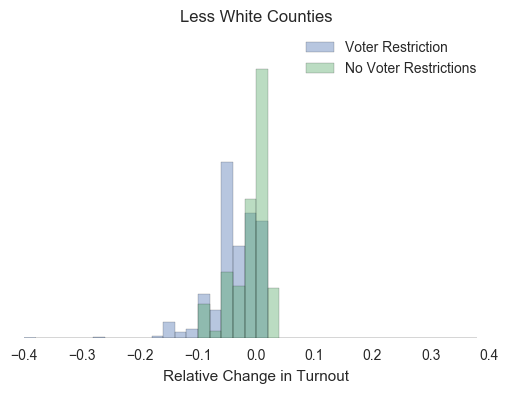

In [124]:
bins = np.arange(-.4, .4, .02)
wa_thresh = .5
plt.title('Less White Counties')
sns.distplot(
    full_pres_df.xs('D', level=1).query('voter_restrictions and wa_frac < {}'.format(wa_thresh)).rel_turnout_change.dropna(),
    kde=False, norm_hist=True,
    bins=bins, label='Voter Restriction',
    hist_kws={
        'weights': full_pres_df.xs('D', level=1).query(
            'voter_restrictions and wa_frac < {}'.format(wa_thresh)
        ).dropna(subset=['rel_turnout_change']).tot_pop
    }
)
sns.distplot(
    full_pres_df.xs('D', level=1).query('not voter_restrictions and wa_frac < {}'.format(wa_thresh)).rel_turnout_change.dropna(),
    kde=False, norm_hist=True,
    bins=bins, label='No Voter Restrictions',
    hist_kws={
        'weights': full_pres_df.xs('D', level=1).query(
            'not voter_restrictions and wa_frac < {}'.format(wa_thresh)
        ).dropna(subset=['rel_turnout_change']).tot_pop
    }
)
plt.gca().axes.get_yaxis().set_visible(False)
plt.xlabel('Relative Change in Turnout')
plt.legend();

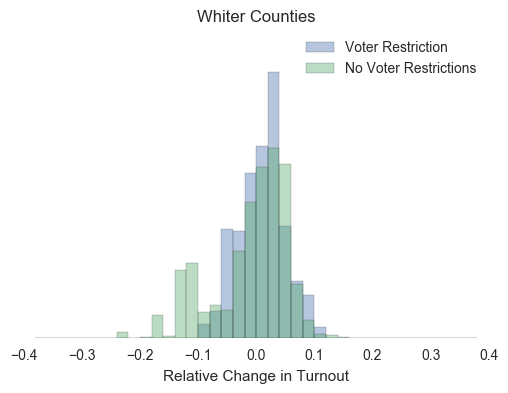

In [123]:
wa_thresh = .5
bins = np.arange(-.4, .4, .02)
plt.title('Whiter Counties')
sns.distplot(
    full_pres_df.xs('D', level=1).query('voter_restrictions and wa_frac >= {}'.format(wa_thresh)).rel_turnout_change.dropna(),
    kde=False, norm_hist=True,
    bins=bins, label='Voter Restriction',
    hist_kws={
        'weights': full_pres_df.xs('D', level=1).query(
            'voter_restrictions and wa_frac >= {}'.format(wa_thresh)
        ).dropna(subset=['rel_turnout_change']).tot_pop
    }
)
sns.distplot(
    full_pres_df.xs('D', level=1).query('not voter_restrictions and wa_frac >= {}'.format(wa_thresh)).rel_turnout_change.dropna(),
    kde=False, norm_hist=True,
    bins=bins, label='No Voter Restrictions',
    hist_kws={
        'weights': full_pres_df.xs('D', level=1).query(
            'not voter_restrictions and wa_frac >= {}'.format(wa_thresh)
        ).dropna(subset=['rel_turnout_change']).tot_pop
    }
)
plt.gca().axes.get_yaxis().set_visible(False)
plt.xlabel('Relative Change in Turnout')
plt.legend();

In [110]:
full_pres_df.query('party!="O"').sort_values('norm_rel_vote_change').join(county_to_code_mapping).dropna().head()

,,votes_2012,percent_won_2012,votes_2016,percent_won_2016,tot_pop,bac_frac,vote_change,rel_vote_change,norm_rel_vote_change,turnout_change,rel_turnout_change,abbr_state,county
fips,party,,,,,,,,,,,,,
28021,D,4838.0,0.882203,2523.0,0.854096,6585.0,0.833257,-2315.0,-0.351557,-0.159757,-2530.0,-0.384207,ms,claiborne
48373,D,4859.0,0.253946,7123.0,0.206799,36429.0,0.114606,2264.0,0.062148,-0.140712,15310.0,0.420270,tx,polk
19089,D,2768.0,0.595910,1674.0,0.371422,6874.0,0.004364,-1094.0,-0.159150,-0.138929,-138.0,-0.020076,ia,howard
20205,R,5650.0,0.760022,2747.0,0.788914,6577.0,0.009579,-2903.0,-0.441387,-0.138133,-3952.0,-0.600882,ks,wilson
29045,D,1398.0,0.433488,724.0,0.218335,5089.0,0.005109,-674.0,-0.132443,-0.137748,91.0,0.017882,mo,clark


In [60]:
full_pres_df.loc[29079]

,votes_2012,percent_won_2012,votes_2016,percent_won_2016,tot_pop,bac_frac,vote_change,rel_vote_change,norm_rel_vote_change
party,,,,,,,,,
D,1212.0,0.277092,780.0,0.176751,7457.0,0.007376,-432.0,-0.057932,-inf
O,132.0,0.030178,171.0,0.038749,7457.0,0.007376,39.0,0.005230,inf
R,3030.0,0.692730,3462.0,0.784500,7457.0,0.007376,432.0,0.057932,inf
